# Классификация жанров музыкальных произведений

## Описание проекта

Музыкальный стриминговый сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Для этого подготовлен датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

## Оглавление

1. [Импорты](#Импорты)
1. [Вспомогательные классы](#helpers)
2. [Осмотр данных](#data-eval)
    1. [Формат предсказаний](#submit-format)
    1. [Формат обучающей выборки](#train-format)
1. [Исследование данных](#eda)
3. [Подготовка данных](#data-prep)
   1. [Кодирование упорядоченных признаков и устранение пропусков в них](#coding)
         1. [Key](#key)
         2. [Mode](#mode)
   2. [Пропуски в количественных признаках](#quant-nans)
         1. [Tempo](#tempo)
   2. [Анализ мультиколлинеарности](#corr)
   1. [Анализ баланса классов](#balance)
1. [Сравнение и оптимизация моделей](#models)
    1. [Разбиение на обучающую и валидационную выборки](#val-split)
    1. [Базовая модель](#baseline)
    2. [Конструирование пайплайна](#pipe)
    1. [Сравнение разных моделей](#model-compare)
    1. [Стэкинг классификаторов с дефолтными гиперпараметрами](#stack)
    1. [Оптимизация гиперпараметров](#hyperparams)
        1. [XGBoost](#xgb-opt)
        1. [MLP](#mlp-opt)
        1. [Ridge](#ridge-opt)
        1. [RandomForest](#rf-opt)
        1. [ExtraTrees](#et-opt)
        1. [KNeighbours](#knn-opt)
        1. [Предсказание оптимизированным XGBoost](#xgb-opt-preds)
        1. [Значимость признаков для мультиклассового XGBoost](#xgb-fi)
    1. [Стэкинг классификаторов с оптимизированными гиперпараметрами](#stack-opt)
    1. [Ансамбль из одноклассовых классификаторов](#one-vs-all)
        1. [Сравнение моделей](#model-compare-ova)
        1. [Оптимизация гиперпараметров](#ova-hyper)
        1. [Конструирование ансамблей](#ova-ens)
        1. [Анализ значимости признаков одноклассового XGBoost](#xgb-mono-fi)
        1. [Оптимизация гиперпараметров Ridge](#ova-hyper-ridge)
        1. [Конструирование ансамблей Ridge](#ova-ens-ridge)   
4. [Итоги](#fin)

# Импорты

In [20]:
import warnings
warnings.filterwarnings('ignore', '.*')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from phik.binning import bin_data

from statsmodels.stats.outliers_influence import variance_inflation_factor

from phik.binning import bin_data

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, LabelBinarizer, PolynomialFeatures

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, cross_validate
from sklearn.metrics import classification_report, roc_auc_score, f1_score, make_scorer

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

import optuna

In [34]:
!pip install feature-engine

In [35]:
from feature_engine.creation import MathFeatures, CyclicalFeatures
from feature_engine.outliers import Winsorizer

## Вспомогательные классы и функции
<a id='helpers'></a>

In [36]:
# для упорядоченного картирования категорий в пайплайне
class idMapper(BaseEstimator, TransformerMixin):
    def __init__(self, dct, key='id'):
        self.key = key
        self.dct= dct

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X[self.key].map(self.dct))
    
    def set_output(self, *, transform=None):
        return self

In [37]:
def f1_macro_avg(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

# Осмотр данных
<a id="data-eval"></a>

In [38]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/music-genre-prediction-m120ds/kaggle_music_genre_test.csv
/kaggle/input/music-genre-prediction-m120ds/sample_submit.csv
/kaggle/input/music-genre-prediction-m120ds/kaggle_music_genre_train.csv


## Формат предсказаний
<a id='submit-format'></a>

In [39]:
!head /kaggle/input/music-genre-prediction-m120ds/sample_submit.csv

instance_id,music_genre
48564,Hip-Hop
72394,Alternative
88081,Rap
78331,Anime
72636,Anime
74228,Rap
39106,Rap
78829,Alternative
91469,Alternative


In [40]:
smpl = pd.read_csv('/kaggle/input/music-genre-prediction-m120ds/sample_submit.csv')
smpl.head()

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Alternative
2,88081,Rap
3,78331,Anime
4,72636,Anime


Формат выходного файла - csv с сохранением поля instance_id, предсказание в виде названия класса должно быть в колонке music_genre.

## Формат обучающей выборки
<a id='train-format'></a>

In [41]:
!head /kaggle/input/music-genre-prediction-m120ds/kaggle_music_genre_train.csv

instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
25143.0,Highwayman,0.48,0.67,182653.0,0.351,0.0176,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.45,Country
26091.0,Toes Across The Floor,0.243,0.452,187133.0,0.67,5.08e-05,A,0.108,-8.392000000000001,Minor,0.0352,113.071,4-Apr,0.539,Rock
87888.0,First Person on Earth,0.228,0.4539999999999999,173448.0,0.804,0.0,E,0.181,-5.225,Minor,0.371,80.98,4-Apr,0.344,Alternative
77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,3.21e-06,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
20852.0,Chasing Shadows,0.2269999999999999,0.742,195333.0,0.575,1.77e-06,C,0.176,-5.55,Major,0.0487,76.494,4-Apr,0.583,Alternative
43934.0,Eskimo Blue Day - Remastered,0.102,0.308,392893.0,0.59,0.371,D,0.1119999999999999,-11.703,Major,0.0345,145.75799999999998,4-Apr,0.496,Blues
23450.0,Living On My Own,0.000234,0.655,218267.0,0.687,2.380

Данные в формате csv со стандартными разделителями и знаком десятичной точки

Первую колонку отправим в индекс - она явно неинформативная

In [42]:
train = pd.read_csv('/kaggle/input/music-genre-prediction-m120ds/kaggle_music_genre_train.csv', 
                    index_col=0)

In [43]:
train.head()

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
instance_id,,,,,,,,,,,,,,,
25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 20394 entries, 25143.0 to 86375.0
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        20394 non-null  object 
 1   acousticness      20394 non-null  float64
 2   danceability      20394 non-null  float64
 3   duration_ms       20394 non-null  float64
 4   energy            20394 non-null  float64
 5   instrumentalness  20394 non-null  float64
 6   key               19659 non-null  object 
 7   liveness          20394 non-null  float64
 8   loudness          20394 non-null  float64
 9   mode              19888 non-null  object 
 10  speechiness       20394 non-null  float64
 11  tempo             19952 non-null  float64
 12  obtained_date     20394 non-null  object 
 13  valence           20394 non-null  float64
 14  music_genre       20394 non-null  object 
dtypes: float64(10), object(5)
memory usage: 2.5+ MB


Типы данных в большинстве разумные, за исключением признака key - его стоит перекодировать в числовой, поскольку тональность - это упорядоченная последовательность высоты звука. Колонку otained_date можно было бы преобразовать в тип дата, но этот признак для классификации жанров выглядит ненадежным в плане генрализуемости, потому можно его оставить, как есть

Видно, что для ряда признаков есть пропуски - key, mode, tempo

In [45]:
test = pd.read_csv('/kaggle/input/music-genre-prediction-m120ds/kaggle_music_genre_test.csv', 
                   index_col=0)

In [46]:
test.head()

,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
instance_id,,,,,,,,,,,,,,
48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121


In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5099 entries, 48564 to 47986
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        5099 non-null   object 
 1   acousticness      5099 non-null   float64
 2   danceability      5099 non-null   float64
 3   duration_ms       5099 non-null   float64
 4   energy            5099 non-null   float64
 5   instrumentalness  5099 non-null   float64
 6   key               4941 non-null   object 
 7   liveness          5099 non-null   float64
 8   loudness          5099 non-null   float64
 9   mode              4950 non-null   object 
 10  speechiness       5099 non-null   float64
 11  tempo             4978 non-null   float64
 12  obtained_date     5099 non-null   object 
 13  valence           5099 non-null   float64
dtypes: float64(10), object(4)
memory usage: 597.5+ KB


Видно, что в тестовых данных типы разумные, точно так же требуется перекодирование key и mode. Также видны пропуски в mode, key и tempo. Поскольку предсказание нужно получить для каждого объекта test, нужно будет каким-то образом эти пропуски заполнить

## Исследование данных
<a id='eda'></a>

In [48]:
train.describe(percentiles=(0.0025, .01, .02, .05,.5,.9, .95, .98, .99, .9975))

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
0.2%,0.000007,0.078300,-1.000000e+00,0.005679,0.000000,0.031298,-34.779407,0.024000,59.438508,0.032298
1%,0.000027,0.132000,-1.000000e+00,0.020172,0.000000,0.041693,-29.524210,0.025300,66.731280,0.036900
2%,0.000069,0.172860,-1.000000e+00,0.037386,0.000000,0.049500,-26.255940,0.026200,71.544400,0.039400
5%,0.000325,0.255000,-1.000000e+00,0.112000,0.000000,0.062400,-20.378450,0.027800,76.523600,0.077200
50%,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
90%,0.864000,0.782000,3.303610e+05,0.925000,0.821000,0.378000,-3.713000,0.238000,164.048800,0.803000


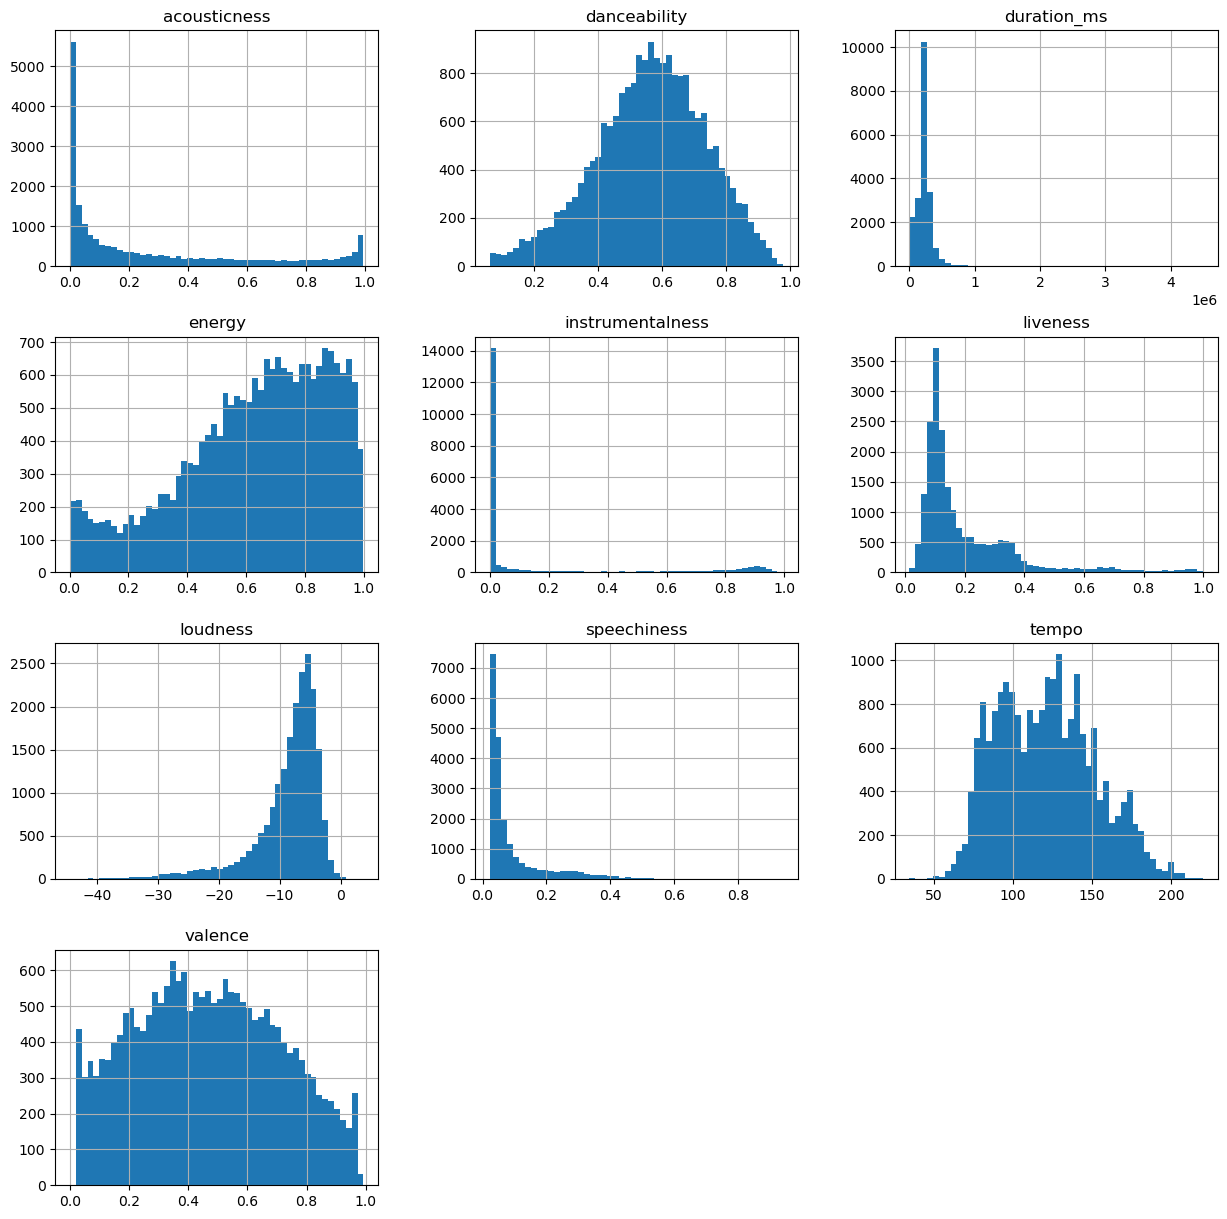

In [49]:
train.hist(bins=50,figsize=(15,15));
plt.show()

Наблюдается следующее поведение признаков:
- acousticness: распределение с двумя пиками в районе 0 и 1 и примерно одинаковой частотой встречаемости в диапазоне 0.3-0.9; выглядит полезным ввести признак, разбивающий данный на три диапазона: 0-0.3, 0.3-0.9 и >0.9
- danceability: приблизительно нормальное распределение без заметных выбросов
- duration: распределение с большим сдвигом вправо; заметен большой хвост из длинных треков
- energy: распределение сдвинутое влево; заметных выбросов нет
- instrunemtalness: видно много нулей в данном поле, распределение похоже на бимодальное
- liveness: распределение похоже на полимодальное, сдвинуто вправо
- loudness: распределение сдвинуто влево, видны редкие значения в области низких значений
- speechiness: распределение сдвинуто вправо; виден большой хвост из больших значений
- tempo: приблизительно нормальное распределение, видны хвосты из редких значений с обеих сторон распределения
- valence: приблизительно нормальное распределение без заметных выбросов

Пробуем удалить аномальные хвосты распределений по 1% и 99% перцентилям

In [50]:
# размер выборки до фильтрации
train.shape

(20394, 15)

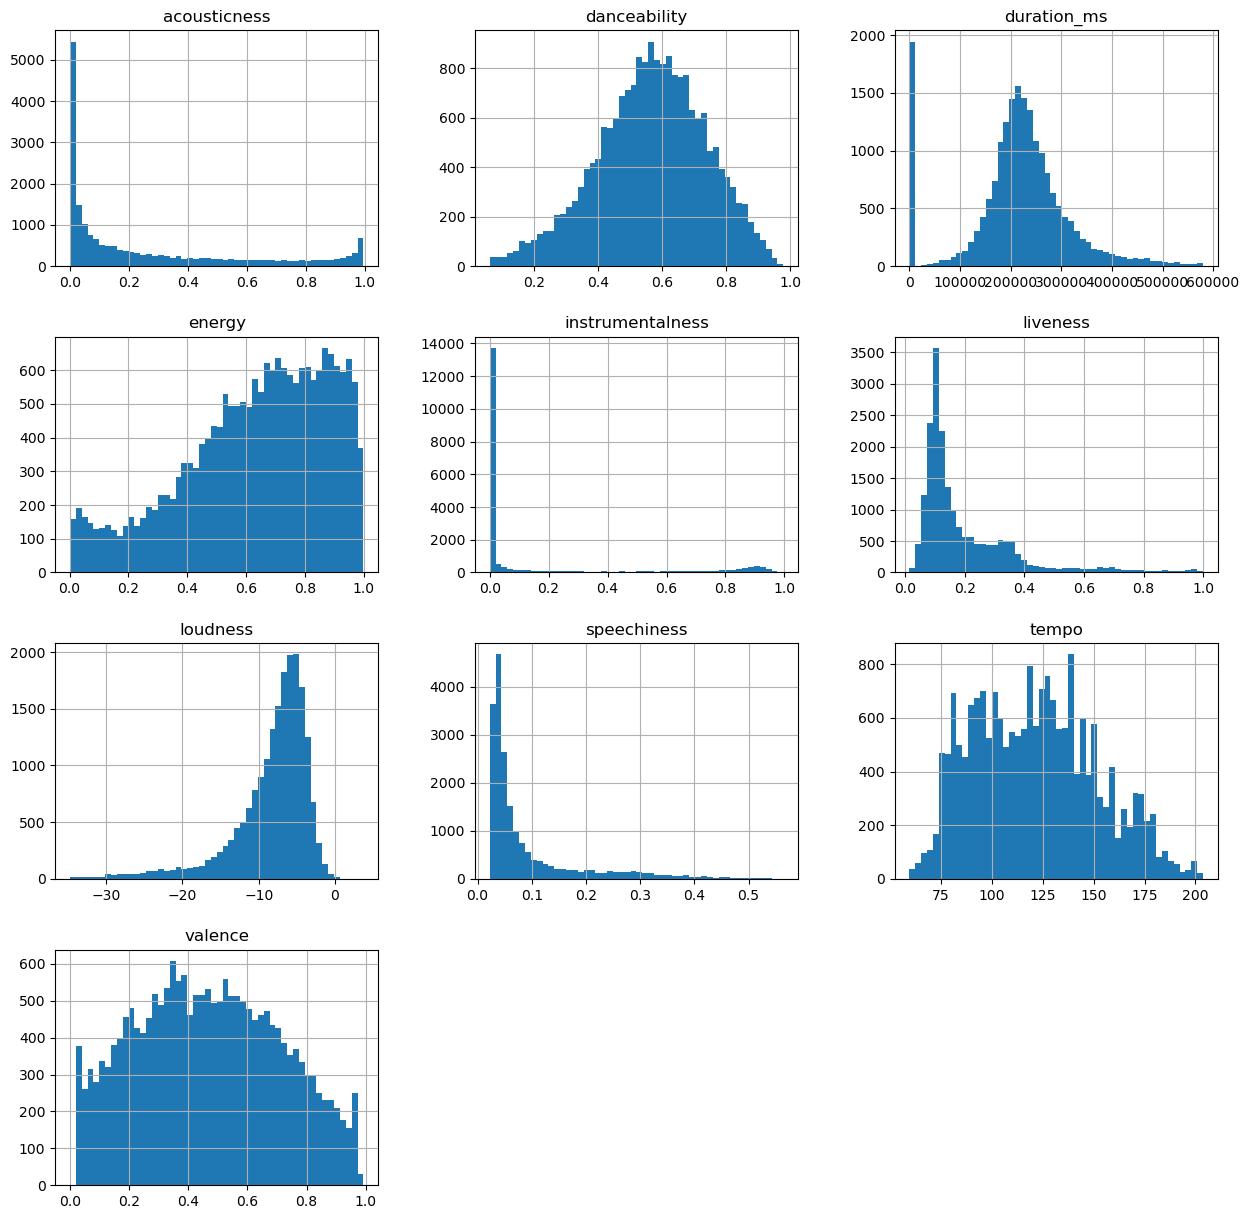

In [51]:
train[
    (train.duration_ms <= 5.801250e+05)
    &(train.loudness >= -34.779407)
    &(train.speechiness <= 0.566000)
    &(train.tempo <= 203.738923)&(train.tempo >= 59.438508)
    ].hist(bins=50, figsize=(15,15));

In [52]:
# Потери данных
train[
    (train.duration_ms <= 5.801250e+05)
    &(train.loudness >= -34.779407)
    &(train.speechiness <= 0.566000)
    &(train.tempo <= 203.738923)&(train.tempo >= 59.438508)  
    ].shape[0] / 20394*100

95.91056192997941

Потери данных составляют порядка 4%, что приемлемо

In [53]:
# Применение фильтрации
train = train[
    (train.duration_ms <= 5.801250e+05)
    &(train.loudness >= -34.779407)
    &(train.speechiness <= 0.566000)
    &(train.tempo <= 203.738923)&(train.tempo >= 59.438508)  
    ]

In [54]:
# Проверяем корреляции для того, чтобы корректно заполнить нули
train[
    (train.duration_ms > 0)
    &(train.instrumentalness > 0)
    ].corr()[['duration_ms','instrumentalness']]

,duration_ms,instrumentalness
acousticness,-0.011454,0.297951
danceability,-0.113687,-0.204377
duration_ms,1.000000,0.104903
energy,-0.020572,-0.304579
instrumentalness,0.104903,1.000000
liveness,0.051661,-0.073344
loudness,-0.061800,-0.445449
speechiness,-0.104155,-0.145162
tempo,-0.011646,-0.093567
valence,-0.128711,-0.246695


- duration_ms: значимых корреляций не видно - будем заполнять модой ненулевых значений
- instrumentalness: есть отрицательная корреляция с loudness и energy, но умеренная

In [55]:
train.loc[train.duration_ms<=0,'duration_ms'] = train.loc[train.duration_ms>0,'duration_ms'].median()

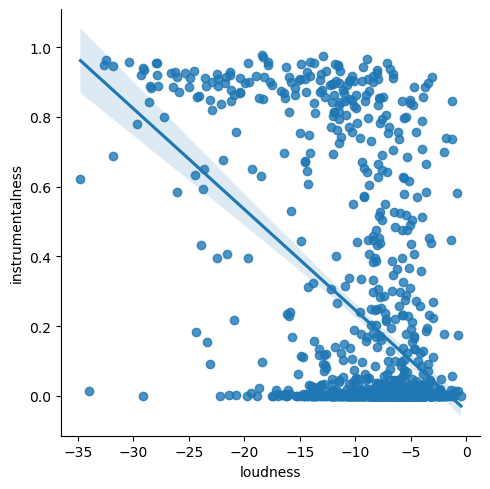

In [56]:
sns.lmplot(data=train[(train.instrumentalness > 0)].sample(1000), x='loudness',y='instrumentalness');

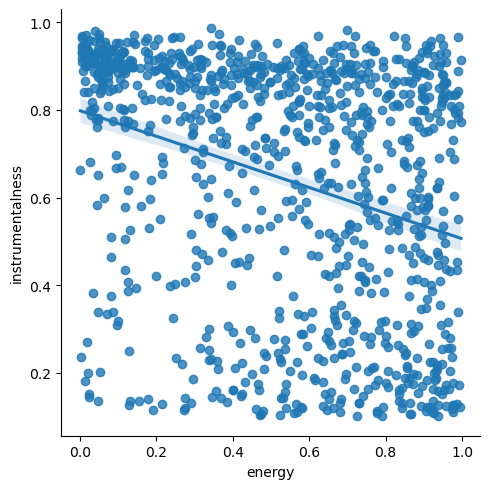

In [57]:
sns.lmplot(data=train[(train.instrumentalness > 0.1)].sample(1000), x='energy',y='instrumentalness');

Разделим данные по критерию loudness < -15 и после этого заполним медианным значением

In [58]:
train.loc[(train.instrumentalness<=0)&(train.loudness<-15),'instrumentalness'] = \
    train.loc[(train.instrumentalness>0)&(train.loudness<-15),'instrumentalness'].median()
train.loc[(train.instrumentalness<=0)&(train.loudness>=-15),'instrumentalness'] = \
    train.loc[(train.instrumentalness>0)&(train.loudness>=-15),'instrumentalness'].median()

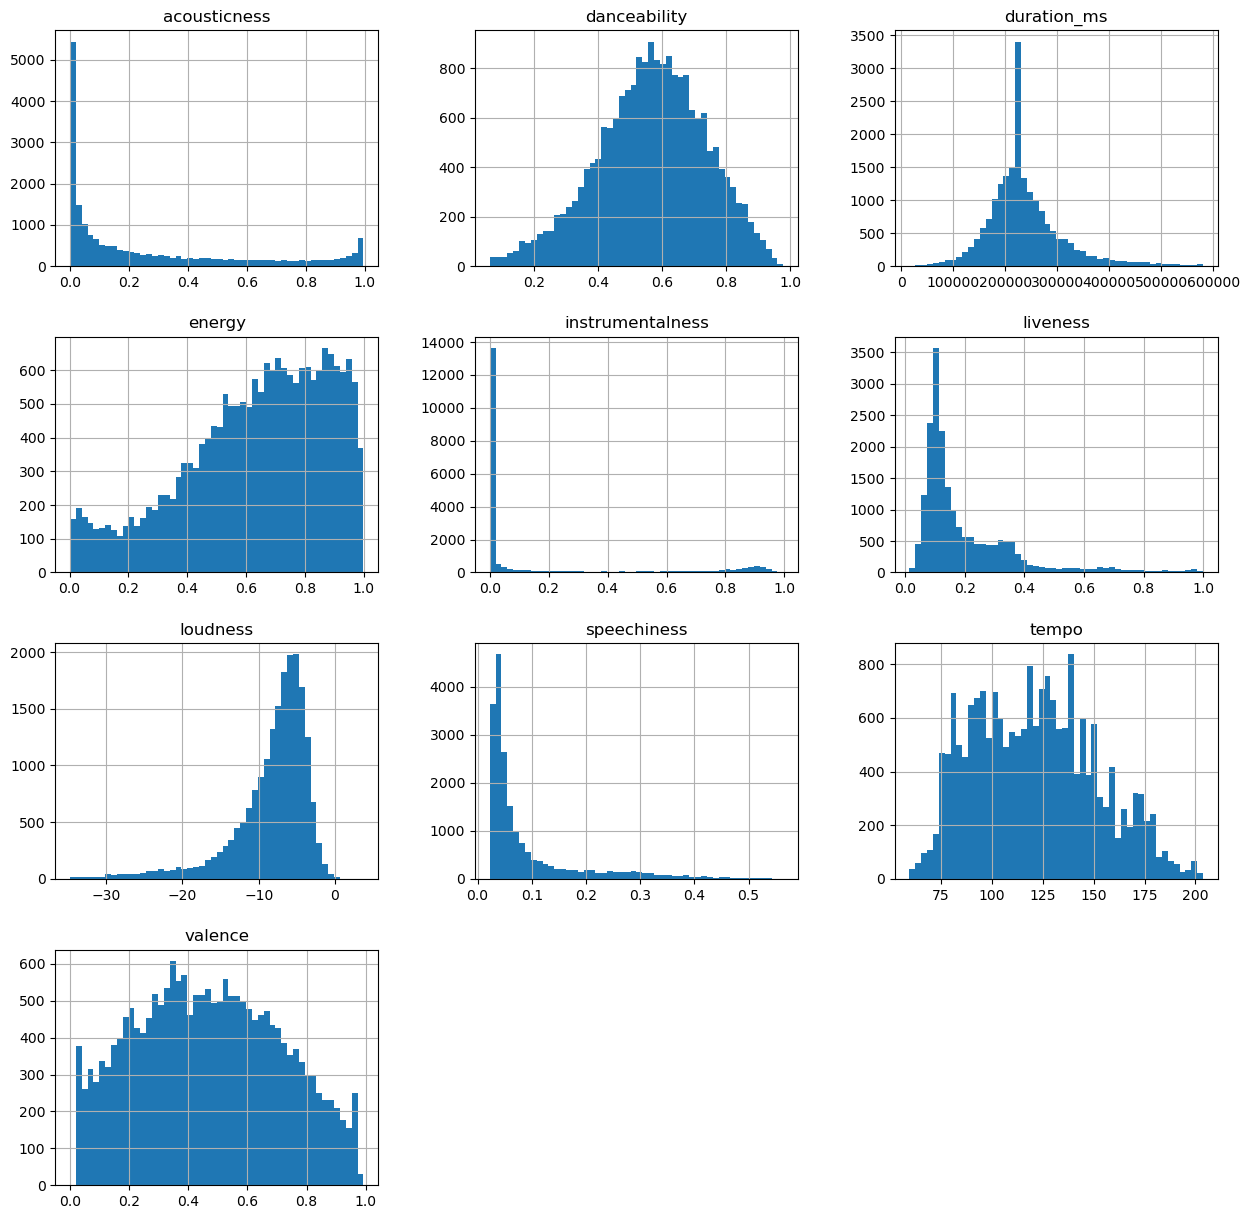

In [59]:
# итоговый вид данных
train.hist(bins=50, figsize=(15,15));

Выглядит полезным разбить на интервалы признаки по следующим отсечкам:
- acousticness 0-0.25, 0.25-0.9, 0.9-..
- instrumentalness 0-0.2, 0.2-0.8, 0.8-..
- liveness 0-0.3, 0.3-0.5, 0.5-0.8, 0.8-..
- speechiness 0-0.15, 0.15-0.35, 0.35-..
- tempo 0-80, 80-110, 110-130, 130-160, 160-180, 180-..

## Подготовка данных
<a id="data-prep"></a>

### Фильтрация неинформативных признаков

Отбрасываем признаки obtained_date и title. Первый из них, скорее всего, не генерализуется, а второй требует отдельной обработки

In [60]:
train = train.drop(['obtained_date', 'track_name'], axis=1)

### Кодирование упорядоченных признаков и устранение в них пропусков
<a id="coding"></a>

#### Key
<a id="key"></a>

In [61]:
# словарь для кодирования тональностией согласно музыкальной теории
keys = {x:y
    for x,y in zip(['C', 'C#', 'D', 'D#','E','F','F#','G','G#','A','A#','B'],
        range(12))
}

In [62]:
train['key'].unique()

array(['D', 'A', 'E', 'G#', 'C', 'D#', 'A#', 'F', 'F#', nan, 'G', 'C#',
       'B'], dtype=object)

Разметка достаточно однородная - исправление регистра и удаление пробелов не требуется

In [63]:
train['key'].isna().sum()/train.shape[0]

0.0364519427402863

Пропусков порядка 3.6%, можно их заполнить наиболее частым значением

In [64]:
train['key'].value_counts(normalize=True)

G     0.117419
C     0.108558
C#    0.108346
D     0.106967
A     0.102191
F     0.082135
B     0.077572
E     0.076617
G#    0.064891
A#    0.062769
F#    0.061920
D#    0.030615
Name: key, dtype: float64

Абсолютного лидера нет, но можно использовать G, поскольку доля заполняемых значений невелика

In [65]:
train['key'] = train['key'].fillna('G')

In [66]:
train['key'] = train['key'].str.strip()

In [67]:
train['key'] = train['key'].map(keys)

#### Mode
<a id='mode'></a>

In [68]:
train['mode'].unique()

array(['Major', 'Minor', nan], dtype=object)

Разметка достаточно однородная - исправление регистра и удаление пробелов не требуется

In [69]:
train['mode'].isna().sum()/train.shape[0]

0.025

Доля пропусков достаточно низкая: порядка 2.5%

In [70]:
train['mode'].value_counts(normalize=True)

Major    0.644539
Minor    0.355461
Name: mode, dtype: float64

Заполняем пропуски наиболее частым значением

In [71]:
train['mode'] = train['mode'].fillna('Major')

Кодируем по словарю, Major как более "громкую" категорию будем обозначать как 1

In [72]:
train['mode'] = train['mode'].map({'Major':1, 'Minor':0})

In [73]:
# Итоговая проверка
train.isna().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
valence             0
music_genre         0
dtype: int64

Итог

Заполнены пропуски в данных:
    
    - mode заполнен наиболее частым значением Major
    - key заполнен наиболее частым значением G
    
Для категориальных признаков key и mode проведено кодирование по словарю, чтобы сохранить взаимное расположение тональностей 

### Анализ мультиколлинеарности
<a id='corr'></a>

Будем проверять наличие коллинеарности с помощью Variance Inflation Factor

In [74]:
# the independent variables set
X = train.iloc[:, :-1]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data.sort_values('VIF'))

             feature        VIF
4   instrumentalness   1.790179
9        speechiness   2.241981
6           liveness   2.593671
8               mode   2.940809
5                key   3.299591
0       acousticness   3.747807
11           valence   6.578083
7           loudness   9.327999
2        duration_ms  11.164354
1       danceability  12.484622
10             tempo  15.753035
3             energy  18.654760


Проведем удаление избыточных признаков по критерию VIF >10

In [75]:
target_vars = list(vif_data[vif_data['VIF']<=10]['feature'].values)
target_vars

['acousticness',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'valence']

In [76]:
# the independent variables set
X = train.loc[:, target_vars]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data.sort_values('VIF'))

            feature       VIF
1  instrumentalness  1.723041
6       speechiness  1.853424
3          liveness  2.281049
5              mode  2.577811
2               key  2.828787
0      acousticness  3.324640
7           valence  3.585755
4          loudness  6.882013


После устранения мультиколлинеарности по критерию VIF>10 в выборке оставлено 9 признаков: 'acousticness',
 'duration_ms',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'valence'

### Баланс классов
<a id='balance'></a>

In [77]:
train['music_genre'].value_counts(normalize=True)*100

Blues          14.018405
Alternative    12.944785
Electronic     12.648262
Rap            12.024540
Rock           10.710634
Country        10.526585
Anime           9.468303
Jazz            6.083845
Classical       5.930470
Hip-Hop         5.644172
Name: music_genre, dtype: float64

Максимальная разница в частотах встречаемости - приблизительно в 3 раза. Следовательно, предсказание доминирующим классом будет работать плохо, но компенсация дисбаланса может быть полезной

## Сравнение и оптимизация моделей
<a id='models'></a>

### Разбиение на обучающую и валидацоиную выборки
<a id='val-split'></a>

Используем стратификацию, чтобы сохранить дисбаланс классов

In [78]:
# повторно загружаем данные, чтобы корректно обработать их в пайплайнах
train = pd.read_csv('/kaggle/input/music-genre-prediction-m120ds/kaggle_music_genre_train.csv', index_col=0)

In [79]:
# Применение фильтрации вручную, т.к. она нужна только для обучающей выборки
train = train[
    (train.duration_ms <= 5.801250e+05)
    &(train.loudness >= -34.779407)
    &(train.speechiness <= 0.566000)
    &(train.tempo <= 203.738923)&(train.tempo >= 59.438508)  
    ]

In [80]:
test = pd.read_csv('/kaggle/input/music-genre-prediction-m120ds/kaggle_music_genre_test.csv', 
                   index_col=0)

In [81]:
y = train['music_genre']
x = train.drop('music_genre', axis=1)

In [82]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [83]:
# собственно генерация обучающей и валидационной выборки
train_idx, val_idx = splitter.split(x, y).__next__()
x_train = x.iloc[train_idx,:]
y_train = y.iloc[train_idx]
x_val = x.iloc[val_idx,:]
y_val = y.iloc[val_idx]

In [84]:
# Кодирование классов для передачи в модель
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_val_bin = lb.transform(y_val)
y_full_bin = lb.transform(y)

Итог

Данные были разбиты на обучающую и валидационную выборку в соотношении 80:20 с использованием стратификации по классам. 

Целевой признак был кодирован с помощью LabelBinarizer

### Базовая модель
<a id='baseline'></a>

Проверим, как работает предсказание доминирующим классом

In [182]:
# Определяем самый частый класс
y_train.value_counts(normalize=True, sort=True, ascending=False).index[0]

'Blues'

In [183]:
preds_val = pd.DataFrame({
    'music_genre':['Blues']*y_val.shape[0]
}, index=y_val.index)

In [184]:
print(f'AUC={roc_auc_score(y_val_bin, lb.transform(preds_val)):.3f}')
print(f'F1={f1_score(y_val_bin, lb.transform(preds_val), average="weighted"):.3f}')

AUC=0.500
F1=0.034


In [185]:
preds_test = pd.DataFrame({
    'music_genre':['Blues']*test.shape[0]
}, index=test.index)

In [186]:
preds_test.to_csv('/kaggle/working/baseline_preds.csv')

Итог

Ожидаемо, в ситуации отсутствия выраженного дисбаланса, предсказание всех образцов валидационной выборки одним классом дает низкое значение метрик: AUC=0.500 и F1=0.034

### Конструирование пайплайна
<a id='pipe'></a>

Для того, чтобы стандартизовать подготовку данных для последующей оптимизации моделей, объединим шаги в пайплайн. При этом добавим следующие шаги:

    - генерация вторичных признаков: полиномиальных, косинусов и синусов для количественных признаков
    - масштабирование с помощью StandardScaler
    - устранение дисбаланса классов в обучающей выборке с помощью SMOTE

In [87]:
# введем класс для фильтрации данных по критерию
class DataBinner(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_res = X.copy()
        binned = bin_data(X, ['acousticness','instrumentalness','liveness','speechiness','tempo'], 
                          {'acousticness':[-1,.25,.9,1],
                     'instrumentalness':[0,.2,.8,1],
                     'liveness':[0,.3,.5,.8,1],
                     'speechiness':[0,.15,.35,1],
                     'tempo':[0,80,110,130,160,180,500]
                    })[['acousticness','instrumentalness','liveness','speechiness','tempo']]
        X_res = X_res.join(binned, rsuffix='_bin')
        return X_res
    
    def set_output(self, *, transform=None):
        return self

In [88]:
# введем класс для заполнения нулей
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, key='duration_ms'):
        self.key = key

    def fit(self, X, y=None):
        if self.key == 'duration_ms':
            self.norm_param = X[X[self.key]>0][self.key].median()
        else:
            self.norm_param1 = X[(X[self.key]>0)&(X['loudness']<-15)][self.key].median()
            self.norm_param2 = X[(X[self.key]>0)&(X['loudness']>=-15)][self.key].median()
        return self

    def transform(self, X, y=None):
        X_res = X.copy()
        if self.key == 'duration_ms':
            X_res.loc[X_res[self.key] <= 0, self.key] = self.norm_param
        else:
            X_res.loc[(X_res[self.key] <= 0)&(X_res['loudness']<-15), self.key] = self.norm_param1
            X_res.loc[(X_res[self.key] <= 0)&(X_res['loudness']>=-15), self.key] = self.norm_param2
        
        return X_res
    
    def set_output(self, *, transform=None):
        return self

In [89]:
# mode и key нуждаются в отдельной обработке
target_vars = [x for x in target_vars if x not in ['mode', 'key']]
target_vars

['acousticness',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'valence']

In [90]:
interval_vars = [x for x in target_vars if x not in ['mode', 'key']]

In [91]:
extended_target_vars = target_vars + \
    [x+'_bin' for x in ['acousticness','instrumentalness','liveness','speechiness','tempo']]

In [92]:
keys = {x:y
    for x,y in zip(['C', 'C#', 'D', 'D#','E','F','F#','G','G#','A','A#','B'],
        range(12))
}

column_trans_nanimpute = ColumnTransformer(
    [
        ('mode', SimpleImputer(strategy='constant', fill_value='Major'), ['mode']),
        ('key', SimpleImputer(strategy='constant', fill_value='G'), ['key']),
        ('others', 'passthrough', extended_target_vars)
    ],
remainder='drop', verbose_feature_names_out=False)

column_trans_encode = ColumnTransformer(
    [
        ('mode', idMapper({'Major':1, 'Minor':0}, 'mode'), ['mode']),
        ('key', idMapper(keys, 'key'), ['key'])
    ],
remainder='passthrough', verbose_feature_names_out=False)

column_trans_zeroimpute = ColumnTransformer(
    [
        ('duration_ms', CustomImputer('duration_ms'), ['duration_ms']),
        ('instrumentalness', CustomImputer('instrumentalness'), ['instrumentalness','loudness'])
    ],
remainder='passthrough', verbose_feature_names_out=False)

In [93]:
scaler = StandardScaler()
smote = SMOTE(random_state=0)
binner = DataBinner()

In [94]:
estimators = [
    ('math_features', 
               PolynomialFeatures(include_bias=False), interval_vars),
                  ('cyc_features', 
                   CyclicalFeatures(variables=interval_vars,
                                   drop_original=True), interval_vars
                  )]
math_features = ColumnTransformer(
    estimators, remainder='passthrough', verbose_feature_names_out=False)

In [95]:
pipe_components = [
                    column_trans_zeroimpute,
                    binner,                    
                    column_trans_nanimpute,
                    column_trans_encode,
                   math_features,
                   scaler
]
test_pipe = make_pipeline(*pipe_components).set_output(transform='pandas')
test_pipe

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('duration_ms',
                                                  CustomImputer(),
                                                  ['duration_ms']),
                                                 ('instrumentalness',
                                                  CustomImputer(key='instrumentalness'),
                                                  ['instrumentalness',
                                                   'loudness'])],
                                   verbose_feature_names_out=False)),
                ('databinner', DataBinner()),
                ('columntransformer-2',
                 ColumnTransformer(transformers...
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'valence']),
                                                 ('cyc_features',
                                                  CyclicalFeatures(drop_original=True,
                                                                   variables=['acousticness',
                                                                              'instrumentalness',
                                                                              'liveness',
                                                                              'loudness',
                                                                              'speechiness',
                                                                              'valence']),
                                                  ['acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'valence'])],
                                   verbose_feature_names_out=False)),
                ('standardscaler', StandardScaler())])

### Сравнение разных моделей
<a id='model-compare'></a>

In [423]:
params = dict(random_state=42)
params.pop('random_state')
clf = XGBClassifier(**params)

pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')

In [ ]:
pipe.fit(x, y_full_bin)

In [ ]:
preds = pd.DataFrame({
    'music_genre':lb.inverse_transform(pipe.predict(test))
}, index=test.index)

In [ ]:
preds.to_csv('/kaggle/working/xgb_preds_ftr.csv')

Итог

Из проверенног набора моделей лидером оказался XGBClassifier с AUC=0.60±0.002;  F1=0.29±0.002. При этом предсказание классов идет с разной эффективностью: 

    XGBClassifier AUC=0.607;  F1=0.292
                  precision    recall  f1-score   support

     Alternative       0.28      0.08      0.12       506
           Anime       0.63      0.29      0.40       370
           Blues       0.50      0.17      0.25       548
       Classical       0.76      0.66      0.71       232
         Country       0.51      0.29      0.37       412
      Electronic       0.62      0.37      0.46       495
         Hip-Hop       0.24      0.10      0.14       221
            Jazz       0.35      0.17      0.23       238
             Rap       0.44      0.24      0.31       471
            Rock       0.21      0.03      0.05       419
        
Лидером является Classical с f1=0.76, а явным аутсайдером  Rock с f1=0.03. При этом представленность данных классов в валидационной выборке отличается только в два раза, причем в пользу Rock.

## Стэкинг классификаторов с дефолтными гиперпараметрами
<a id='stack'></a>

Для стэкинга используем набор классификаторов, работающих на разных принципах: бустинг над решающими деревьями XGBoost, многослойный перцептрон, линейную регрессию с L2 регуляризацией, метод ближайших соседей и случайный лес в двух вариантах.

В качестве финального классификатора используем случайный лес, чтобы он мог более точно подстроиться под результаты других классификаторов

In [128]:
estimators = [
    ('xgb', XGBClassifier()),
    ('mlp', MLPClassifier()), 
    ('ridge', RidgeClassifier()), 
    ('knn', KNeighborsClassifier()),
    ('et', ExtraTreesClassifier())
]
fitted_estimators = []
for i in range(len(estimators)):
    print(f'Fitting {estimators[i][0]}')
    pipe = make_pipeline(*pipe_components+[smote]+[estimators[i][1]]).set_output(transform='pandas')
    pipe.fit(x_train, y_train_bin)
    fitted_estimators.append(pipe.steps[-1])
    
clf = StackingClassifier(estimators=fitted_estimators, final_estimator=RandomForestClassifier(), 
                         stack_method='predict',cv='prefit', verbose=2)

Fitting xgb
Fitting mlp
Fitting ridge
Fitting knn
Fitting et


In [129]:
pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')
pipe

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('duration_ms',
                                                  CustomImputer(),
                                                  ['duration_ms']),
                                                 ('instrumentalness',
                                                  CustomImputer(key='instrumentalness'),
                                                  ['instrumentalness',
                                                   'loudness'])],
                                   verbose_feature_names_out=False)),
                ('databinner', DataBinner()),
                ('columntransformer-2',
                 ColumnTransformer(transformers...
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...)),
                                                ('mlpclassifier',
                                                 MLPClassifier()),
                                                ('ridgeclassifier',
                                                 RidgeClassifier()),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier()),
                                                ('extratreesclassifier',
                                                 ExtraTreesClassifier())],
                                    final_estimator=RandomForestClassifier(),
                                    stack_method='predict', verbose=2))])

In [201]:
pipe.fit(x, y_full_bin)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   47.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(transformers=[('mode',
                                                  SimpleImputer(fill_value='Major',
                                                                strategy='constant'),
                                                  ['mode']),
                                                 ('key',
                                                  SimpleImputer(fill_value='G',
                                                                strategy='constant'),
                                                  ['key']),
                                                 ('others', 'passthrough',
                                                  ['acousticness',
                                                   'duration_ms',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'valence'])],
                                   verbose_feature_nam...
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None, ...)),
                                                ('mlp', MLPClassifier()),
                                                ('ridge', RidgeClassifier()),
                                                ('knn', KNeighborsClassifier()),
                                                ('et', ExtraTreesClassifier())],
                                    final_estimator=RandomForestClassifier(),
                                    stack_method='predict', verbose=2))])

In [202]:
preds = pd.DataFrame({
    'music_genre':lb.inverse_transform(pipe.predict(test))
}, index=test.index)

In [203]:
preds.to_csv('/kaggle/working/ens_preds.csv')

Итог

Стэкинг классификаторов не дал существенного прироста качества на отложенной выборке; предполагаем, что он может стать лучше после оптимизации гиперпараметров каждой из моделей

## Оптимизация гиперпараметров
<a id='hyperparams'></a>

Будем оптимизировать гиперпараметры каждого из классификаторов с помощью библиотеки optuna с трехкратной кросс-валидацией. После оптимизации для того, чтобы в дальнейшем не пересчитывать, будем сохранять результат в отдельной ячейке с отключением исполнимости оптимизатора.

В качестве целевой метрики будем использовать F1 в режиме weighted, чтобы учесть неоднородность в распределении классов.

### XGB
<a id='xgb-opt'></a>

In [428]:
def objective(trial):

    param = {
        "verbosity": 0,
#         "objective": "multi:softmax",
#         "num_class": y_train_bin.shape[1],
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    clf = XGBClassifier(**param)
    pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')    
    
    
    score = cross_val_score(pipe, x_train, y_train_bin, cv=3,
                           groups = y_train,
                           scoring=make_scorer(f1_macro_avg))
    
    return score.mean()

### MLP
<a id='mpl-opt'></a>

In [430]:
def objective(trial:optuna.Trial):

    param = dict(
        hidden_layer_sizes=trial.suggest_int('hidden_layer_sizes', 10,200),
        activation=trial.suggest_categorical('activation',['identity', 'logistic', 'tanh', 'relu']),
        alpha=trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        batch_size=trial.suggest_int('batch_size', 10,200)
    )    

    clf = MLPClassifier(**param)
    pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')    
    
    
    score = cross_val_score(pipe, x_train, y_train_bin, cv=3,
                           groups = y_train,
                           scoring=make_scorer(f1_macro_avg))
    
    return score.mean()

### RF
<a id='rf-opt'></a>

In [432]:
def objective(trial):

    param = dict(
        n_estimators=trial.suggest_int('n_estimators', 10,500),
        max_depth=trial.suggest_int('max_depth', 2,30),
        max_features=trial.suggest_int('max_features', 2,30)
    )

    clf = RandomForestClassifier(**param)
    pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')    
    
    
    score = cross_val_score(pipe, x_train, y_train_bin, cv=3,
                           groups = y_train,
                           scoring=make_scorer(f1_macro_avg))
    
    return score.mean()

### ExtraTrees
<a id='et-opt'></a>

In [434]:
def objective(trial):

    param = dict(
        n_estimators=trial.suggest_int('n_estimators', 10,1000),
        max_depth=trial.suggest_int('max_depth', 2,30),
        max_features=trial.suggest_int('max_features', 2,30)
    )

    clf = ExtraTreesClassifier(**param)
    pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')    
    
    
    score = cross_val_score(pipe, x_train, y_train_bin, cv=3,
                           groups = y_train,
                           scoring=make_scorer(f1_macro_avg))
    
    return score.mean()

### Ridge
<a id='ridge-opt'></a>

In [436]:
def objective(trial):

    param = {
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True)
    }

    clf = RidgeClassifier(**param)
    pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')    
    
    
    score = cross_val_score(pipe, x_train, y_train_bin, cv=3,
                           groups = y_train,
                           scoring=make_scorer(f1_macro_avg))
    
    return score.mean()

### KNeighbours
<a id='knn-opt'></a>

In [96]:
def objective(trial):

    param = dict(
        n_neighbors=trial.suggest_int('n_neighbors', 3,500)
    )

    clf = KNeighborsClassifier(**param)
    pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')    
    
    
    score = cross_val_score(pipe, x_train, y_train_bin, cv=3,
                           groups = y_train,
                           scoring=make_scorer(f1_macro_avg))
    
    return score.mean()

### Предсказание оптимизированным XGBoost
<a id='xgb-opt-preds'></a>

In [99]:
clf = XGBClassifier(**{
        'booster': 'dart',
        'lambda': 0.002606983151278242,
        'alpha': 2.995024900424555e-08,
        'subsample': 0.2326605044147615,
        'colsample_bytree': 0.8625309760802649,
        'max_depth': 7,
        'min_child_weight': 5,
        'eta': 0.4962796421364526,
        'gamma': 0.145050619355437,
        'grow_policy': 'depthwise',
        'sample_type': 'weighted',
        'normalize_type': 'forest',
        'rate_drop': 1.3303565395229203e-08,
        'skip_drop': 8.358343920156023e-06})

pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')

In [237]:
pipe.fit(x, y_full_bin)

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(transformers=[('mode',
                                                  SimpleImputer(fill_value='Major',
                                                                strategy='constant'),
                                                  ['mode']),
                                                 ('key',
                                                  SimpleImputer(fill_value='G',
                                                                strategy='constant'),
                                                  ['key']),
                                                 ('others', 'passthrough',
                                                  ['acousticness',
                                                   'duration_ms',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'valence'])],
                                   verbose_feature_nam...
                               gamma=0.004426549681742661, gpu_id=None,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints=None,
                               lambda=1.211264940029101e-06, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None, ...))])

In [238]:
preds = pd.DataFrame({
    'music_genre':lb.inverse_transform(pipe.predict(test))
}, index=test.index)

In [239]:
preds.to_csv('/kaggle/working/xgb_preds_ftr_opt.csv')

### Анализ значимости признаков мультиклассового XGBoost
<a id='xgb-fi'></a>

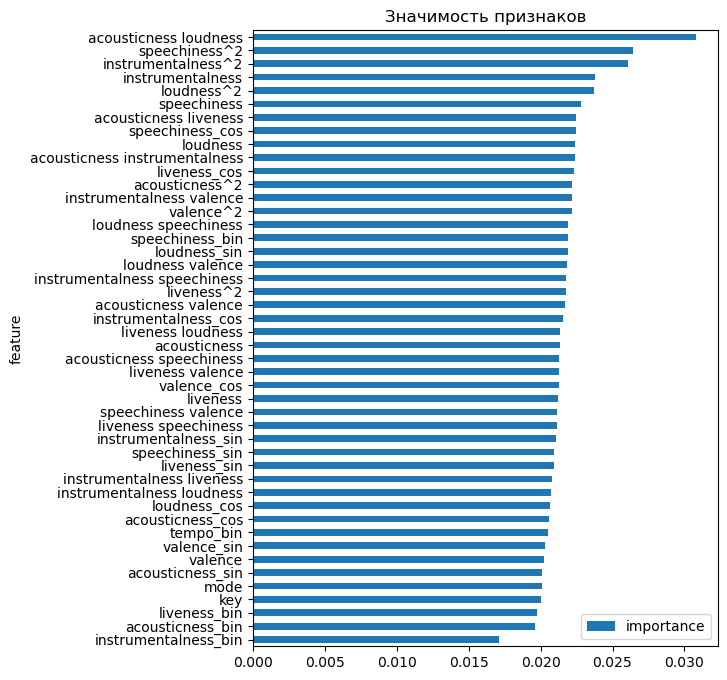

In [113]:
fi_df = pd.DataFrame({'feature':pipe.steps[-1][1].feature_names_in_,
                     'importance':pipe.steps[-1][1].feature_importances_}).sort_values('importance').set_index('feature')
fi_df.plot(kind='barh', figsize=(6,8));
plt.title('Значимость признаков');

### Стэкинг классификаторов с оптимизированными гиперпараметрами
<a id='stack-opt'></a>

In [131]:
# Поскольку мы используем пайплайн для обучения моделей, обучим предварительно классификаторы 
# и только потом передадим их в ансамбль
estimators = [
    ('xgb', XGBClassifier(**{
        'booster': 'dart',
        'lambda': 0.002606983151278242,
        'alpha': 2.995024900424555e-08,
        'subsample': 0.2326605044147615,
        'colsample_bytree': 0.8625309760802649,
        'max_depth': 7,
        'min_child_weight': 5,
        'eta': 0.4962796421364526,
        'gamma': 0.145050619355437,
        'grow_policy': 'depthwise',
        'sample_type': 'weighted',
        'normalize_type': 'forest',
        'rate_drop': 1.3303565395229203e-08,
        'skip_drop': 8.358343920156023e-06})),
    ('mlp', MLPClassifier(**{
        'hidden_layer_sizes': 197,
        'activation': 'relu',
        'alpha': 4.2352422835093816e-08,
        'batch_size': 28
    })), 
    ('ridge', RidgeClassifier(**{
        'alpha': 6.454690914899587e-07
    })), 
    ('knn', KNeighborsClassifier(**{
        'n_neighbors': 5
    })),
    ('et', ExtraTreesClassifier(**{
        'n_estimators': 733,
        'max_depth': 30,
        'max_features': 30
    }))
]
fitted_estimators = []
for i in range(len(estimators)):
    print(f'Fitting {estimators[i][0]}')
    pipe = make_pipeline(*pipe_components+[smote]+[estimators[i][1]]).set_output(transform='pandas')
    pipe.fit(x_train, y_train_bin)
    fitted_estimators.append(pipe.steps[-1])

Fitting xgb
Fitting mlp
Fitting ridge
Fitting knn
Fitting et


In [132]:
clf = StackingClassifier(estimators=fitted_estimators, final_estimator=RandomForestClassifier(), 
                         stack_method='predict',cv='prefit', verbose=2)

In [133]:
pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')

In [134]:
pipe

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('duration_ms',
                                                  CustomImputer(),
                                                  ['duration_ms']),
                                                 ('instrumentalness',
                                                  CustomImputer(key='instrumentalness'),
                                                  ['instrumentalness',
                                                   'loudness'])],
                                   verbose_feature_names_out=False)),
                ('databinner', DataBinner()),
                ('columntransformer-2',
                 ColumnTransformer(transformers...
                                                 MLPClassifier(alpha=4.2352422835093816e-08,
                                                               batch_size=28,
                                                               hidden_layer_sizes=197)),
                                                ('ridgeclassifier',
                                                 RidgeClassifier(alpha=6.454690914899587e-07)),
                                                ('kneighborsclassifier',
                                                 KNeighborsClassifier()),
                                                ('extratreesclassifier',
                                                 ExtraTreesClassifier(max_depth=30,
                                                                      max_features=30,
                                                                      n_estimators=733))],
                                    final_estimator=RandomForestClassifier(),
                                    stack_method='predict', verbose=2))])

In [232]:
pipe.fit(x, y_full_bin)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(transformers=[('mode',
                                                  SimpleImputer(fill_value='Major',
                                                                strategy='constant'),
                                                  ['mode']),
                                                 ('key',
                                                  SimpleImputer(fill_value='G',
                                                                strategy='constant'),
                                                  ['key']),
                                                 ('others', 'passthrough',
                                                  ['acousticness',
                                                   'duration_ms',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'valence'])],
                                   verbose_feature_nam...
                                                               n_jobs=None, ...)),
                                                ('mlp',
                                                 MLPClassifier(alpha=3.04341312811999e-06,
                                                               batch_size=33,
                                                               hidden_layer_sizes=168)),
                                                ('ridge',
                                                 RidgeClassifier(alpha=1.4002521049585357e-07)),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=3)),
                                                ('et',
                                                 ExtraTreesClassifier(max_depth=17,
                                                                      max_features=21,
                                                                      n_estimators=283))],
                                    final_estimator=RandomForestClassifier(),
                                    stack_method='predict', verbose=2))])

In [233]:
preds = pd.DataFrame({
    'music_genre':lb.inverse_transform(pipe.predict(test))
}, index=test.index)

In [234]:
preds.to_csv('/kaggle/working/ens_preds_opt.csv')

### Ансамбль из одноклассовых классификаторов
<a id='one-vs-all'></a>

#### Сравнение разных моделей
<a id='model-compare-ova'></a>

#### Оптимизация гиперпараметров
<a id='ova-hyper'></a>

In [138]:
def objective(trial):

    param = {
        "verbosity": 0,
#         "objective": "multi:softmax",
#         "num_class": y_train_bin.shape[1],
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    clf = XGBClassifier(**param)
    pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')    
    
    y_train_tmp = y_train == 'Rock'
    score = cross_val_score(pipe, x_train, y_train_tmp, cv=3,
                           scoring=make_scorer(f1_macro_avg))
    
    return score.mean()

#### Ансамблирование
<a id='ova-ens'></a>

Теперь с оптимальными параметрами получим классификатор для каждого из классов

In [140]:
estimators = []
for tgt_class in y_train.unique():    
    
    clf = XGBClassifier(**{'booster': 'dart', 
                           'lambda': 1.747797532951536e-06, 
                           'alpha': 0.0009037314662488365, 
                           'subsample': 0.8750150809635113, 
                           'colsample_bytree': 0.9889277035147467, 
                           'max_depth': 9, 
                           'min_child_weight': 3, 
                           'eta': 0.07587170961396335, 
                           'gamma': 5.248575436687877e-07, 
                           'grow_policy': 'lossguide', 
                           'sample_type': 'weighted', 
                           'normalize_type': 'forest', 
                           'rate_drop': 0.0007256287638602401, 
                           'skip_drop': 6.912897695941525e-07})
    pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')
    
    y_train_tmp = (y_train == tgt_class)
    y_val_tmp = (y_val == tgt_class)
    pipe.fit(x_train, y_train_tmp)
    print(f'XGBClassifier for {tgt_class} AUC={roc_auc_score(y_val_tmp, pipe.predict(x_val)):.3f}; ',
         f'F1={f1_macro_avg(y_val_tmp, pipe.predict(x_val)):.3f}')
    print(classification_report(y_val_tmp, pipe.predict(x_val)))
    estimators.append(pipe.steps[-1])

XGBClassifier for Blues AUC=0.639;  F1=0.840
              precision    recall  f1-score   support

       False       0.90      0.93      0.91      3364
        True       0.44      0.35      0.39       548

    accuracy                           0.85      3912
   macro avg       0.67      0.64      0.65      3912
weighted avg       0.83      0.85      0.84      3912

XGBClassifier for Hip-Hop AUC=0.584;  F1=0.912
              precision    recall  f1-score   support

       False       0.95      0.96      0.95      3691
        True       0.22      0.21      0.22       221

    accuracy                           0.91      3912
   macro avg       0.59      0.58      0.59      3912
weighted avg       0.91      0.91      0.91      3912

XGBClassifier for Rock AUC=0.509;  F1=0.839
              precision    recall  f1-score   support

       False       0.89      0.97      0.93      3493
        True       0.16      0.05      0.07       419

    accuracy                           0.87   

In [144]:
estimators2 = [(y, x[1]) for x,y in zip(estimators, y_train.unique())]

In [145]:
clf = StackingClassifier(estimators=estimators2, final_estimator=RandomForestClassifier(), 
                         stack_method='predict_proba',cv='prefit', verbose=2)

In [146]:
pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')

In [232]:
pipe.fit(x, y_full_bin)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(transformers=[('mode',
                                                  SimpleImputer(fill_value='Major',
                                                                strategy='constant'),
                                                  ['mode']),
                                                 ('key',
                                                  SimpleImputer(fill_value='G',
                                                                strategy='constant'),
                                                  ['key']),
                                                 ('others', 'passthrough',
                                                  ['acousticness',
                                                   'duration_ms',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'valence'])],
                                   verbose_feature_nam...
                                                               n_jobs=None, ...)),
                                                ('mlp',
                                                 MLPClassifier(alpha=3.04341312811999e-06,
                                                               batch_size=33,
                                                               hidden_layer_sizes=168)),
                                                ('ridge',
                                                 RidgeClassifier(alpha=1.4002521049585357e-07)),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=3)),
                                                ('et',
                                                 ExtraTreesClassifier(max_depth=17,
                                                                      max_features=21,
                                                                      n_estimators=283))],
                                    final_estimator=RandomForestClassifier(),
                                    stack_method='predict', verbose=2))])

In [233]:
preds = pd.DataFrame({
    'music_genre':lb.inverse_transform(pipe.predict(test))
}, index=test.index)

In [234]:
preds.to_csv('/kaggle/working/ens_preds_ova.csv')

### Анализ значимости признаков одноклассового XGBoost
<a id='xgb-mono-fi'></a>

In [148]:
clf = XGBClassifier(**{'booster': 'dart', 
                           'lambda': 1.747797532951536e-06, 
                           'alpha': 0.0009037314662488365, 
                           'subsample': 0.8750150809635113, 
                           'colsample_bytree': 0.9889277035147467, 
                           'max_depth': 9, 
                           'min_child_weight': 3, 
                           'eta': 0.07587170961396335, 
                           'gamma': 5.248575436687877e-07, 
                           'grow_policy': 'lossguide', 
                           'sample_type': 'weighted', 
                           'normalize_type': 'forest', 
                           'rate_drop': 0.0007256287638602401, 
                           'skip_drop': 6.912897695941525e-07})

pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')

In [149]:
y_train_tmp = (y_train == tgt_class)
y_val_tmp = (y_val == tgt_class)
pipe.fit(x_train, y_train_tmp)

Pipeline(steps=[('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('duration_ms',
                                                  CustomImputer(),
                                                  ['duration_ms']),
                                                 ('instrumentalness',
                                                  CustomImputer(key='instrumentalness'),
                                                  ['instrumentalness',
                                                   'loudness'])],
                                   verbose_feature_names_out=False)),
                ('databinner', DataBinner()),
                ('columntransformer-2',
                 ColumnTransformer(transformers...
                               feature_types=None, gamma=5.248575436687877e-07,
                               gpu_id=None, grow_policy='lossguide',
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=1.747797532951536e-06, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None, ...))])

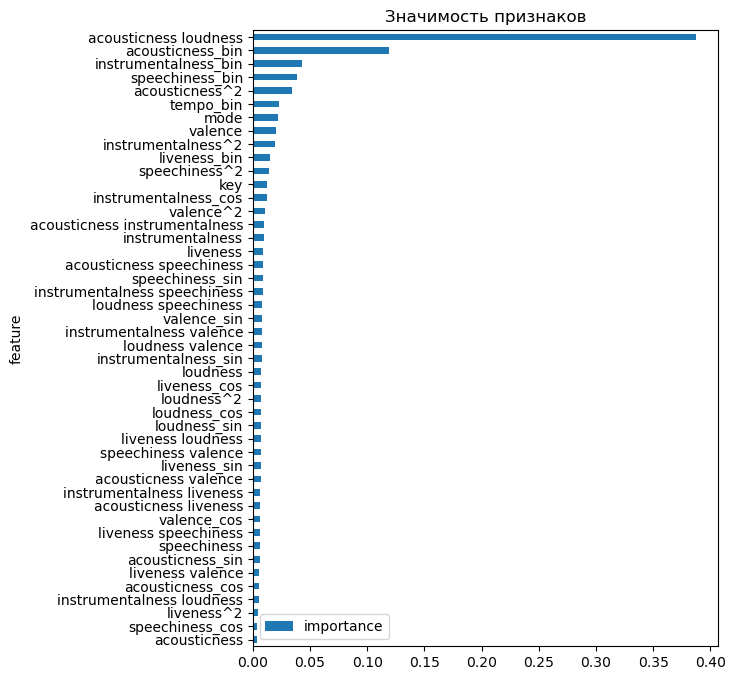

In [150]:
fi_df = pd.DataFrame({'feature':pipe.steps[-1][1].feature_names_in_,
                     'importance':pipe.steps[-1][1].feature_importances_}).sort_values('importance').set_index('feature')
fi_df.plot(kind='barh', figsize=(6,8));
plt.title('Значимость признаков');

#### Оптимизация гиперпараметров Ridge
<a id='ova-hyper-ridge'></a>

In [158]:
def objective(trial):

    param = {
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0)
    }

    clf = RidgeClassifier(**param)
    pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')    
    
    y_train_tmp = y_train == 'Rock'
    score = cross_val_score(pipe, x_train, y_train_tmp, cv=3,
                           scoring=make_scorer(f1_macro_avg))
    
    return score.mean()

#### Ансамблирование Ridge
<a id='ova-ens-ridge'></a>

Теперь с оптимальными параметрами получим классификатор для каждого из классов

In [160]:
estimators = []
for tgt_class in y_train.unique():    
    
    clf = RidgeClassifier(**{'alpha': 0.11755082943055037})
    pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')
    
    y_train_tmp = (y_train == tgt_class)
    y_val_tmp = (y_val == tgt_class)
    pipe.fit(x_train, y_train_tmp)
    print(f'RidgeClassifier for {tgt_class} AUC={roc_auc_score(y_val_tmp, pipe.predict(x_val)):.3f}; ',
         f'F1={f1_macro_avg(y_val_tmp, pipe.predict(x_val)):.3f}')
    print(classification_report(y_val_tmp, pipe.predict(x_val)))
    estimators.append(pipe.steps[-1])

RidgeClassifier for Blues AUC=0.700;  F1=0.734
              precision    recall  f1-score   support

       False       0.94      0.68      0.79      3364
        True       0.27      0.72      0.39       548

    accuracy                           0.69      3912
   macro avg       0.60      0.70      0.59      3912
weighted avg       0.84      0.69      0.73      3912

RidgeClassifier for Hip-Hop AUC=0.776;  F1=0.833
              precision    recall  f1-score   support

       False       0.98      0.77      0.87      3691
        True       0.17      0.78      0.28       221

    accuracy                           0.77      3912
   macro avg       0.58      0.78      0.57      3912
weighted avg       0.94      0.77      0.83      3912

RidgeClassifier for Rock AUC=0.667;  F1=0.676
              precision    recall  f1-score   support

       False       0.95      0.58      0.72      3493
        True       0.18      0.75      0.29       419

    accuracy                           0

In [161]:
estimators2 = [(y, x[1]) for x,y in zip(estimators, y_train.unique())]

In [165]:
clf = StackingClassifier(estimators=estimators2, final_estimator=RandomForestClassifier(), 
                         stack_method='predict',cv='prefit', verbose=2)

In [166]:
pipe = make_pipeline(*pipe_components+[smote]+[clf]).set_output(transform='pandas')

Высокое значение AUC для RidgeClassifier не приводит к эффективному ансамблю

# Итог
<a id='fin'></a>

Музыкальный стриминговый сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Для этого подготовлен датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

### 1. Осмотр данных

В обучающей выборке доступно 20394 объекта. Типы данных в большинстве разумные, за исключением признака key - его необходимо было перекодировать в числовой, поскольку тональность - это упорядоченная последовательность высоты звука. Колонку otained_date можно было бы преобразовать в тип дата, но этот признак для классификации жанров выглядит ненадежным в плане генрализуемости, потому их оставили, как есть

Видно, что для ряда признаков есть пропуски - key, mode, tempo.

### 2. Исследование данных.

Наблюдается следующее поведение признаков:
- acousticness: распределение с двумя пиками в районе 0 и 1 и примерно одинаковой частотой встречаемости в диапазоне 0.3-0.9; выглядит полезным ввести признак, разбивающий данный на три диапазона: 0-0.3, 0.3-0.9 и >0.9
- danceability: приблизительно нормальное распределение без заметных выбросов
- duration: распределение с большим сдвигом вправо; заметен большой хвост из длинных треков
- energy: распределение сдвинутое влево; заметных выбросов нет
- instrunemtalness: видно много нулей в данном поле, распределение похоже на бимодальное
- liveness: распределение похоже на полимодальное, сдвинуто вправо
- loudness: распределение сдвинуто влево, видны редкие значения в области низких значений
- speechiness: распределение сдвинуто вправо; виден большой хвост из больших значений
- tempo: приблизительно нормальное распределение, видны хвосты из редких значений с обеих сторон распределения
- valence: приблизительно нормальное распределение без заметных выбросов

Аномальные хвосты распределений было решено удалить по 1% и 99% перцентилям. Потери данных составили порядка 4%, что приемлемо

Для признаков duration_ms и instrumentalness обнаружено большое количество нулевых значений. Было решено, что это пропуски. Заполнение проводили после анализ корреляций с другими признаками.

- duration_ms: значимых корреляций не видно - будем заполнять модой ненулевых значений
- instrumentalness: есть отрицательная корреляция с loudness и energy, но умеренная

По форме распределений было принято решение разбить на интервалы признаки по следующим отсечкам:
- acousticness 0-0.25, 0.25-0.9, 0.9-..
- instrumentalness 0-0.2, 0.2-0.8, 0.8-..
- liveness 0-0.3, 0.3-0.5, 0.5-0.8, 0.8-..
- speechiness 0-0.15, 0.15-0.35, 0.35-..
- tempo 0-80, 80-110, 110-130, 130-160, 160-180, 180-..

### 3. Подготовка данных

Были отброшены признаки obtained_date и title. Первый из них, скорее всего, не генерализуется, а второй требует отдельной обработки

Заполнены пропуски в данных:
    
- mode заполнен наиболее частым значением Major
- key заполнен наиболее частым значением G
    
Для категориальных признаков key и mode проведено кодирование по словарю, чтобы сохранить взаимное расположение тональностей 

После устранения мультиколлинеарности по критерию VIF>10 в выборке оставлено 9 признаков: 'acousticness',
 'duration_ms',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'valence'
 
### 4. Анализ баланса классов

Максимальная разница в частотах встречаемости - приблизительно в 3 раза. Следовательно, предсказание доминирующим классом будет работать плохо, но компенсация дисбаланса может быть полезной. Принято решение компенсировать дисбаланс оверсэмплингом с помощью SMOTE из библиотеки imbalanced-learn

### 5. Подготовка выборок для обучения

Данные были разбиты на обучающую и валидационную выборку в соотношении 80:20 с использованием стратификации по классам. 

Целевой признак был кодирован с помощью LabelBinarizer

Для того, чтобы стандартизовать подготовку данных для последующей оптимизации моделей, объединим шаги в пайплайн. При этом добавим следующие шаги:

- генерация вторичных признаков: полиномиальных, косинусов и синусов для количественных признаков
- масштабирование с помощью StandardScaler
- устранение дисбаланса классов в обучающей выборке с помощью SMOTE

### 6. Обучение моделей

#### 6.1. Базовая линия

Ожидаемо, в ситуации отсутствия выраженного дисбаланса, предсказание всех образцов валидационной выборки одним классом дает низкое значение метрик: AUC=0.500 и F1=0.034

#### 6.2. Сравнение моделей

На валидационной выборке протестированные в режиме многоклассовой классификации модели показали следующие результаты:

    XGBClassifier AUC=0.60±0.001;  F1=0.27±0.003
    MLPClassifier AUC=0.61±0.004;  F1=0.26±0.011
    RidgeClassifier AUC=0.55±0.002;  F1=0.10±0.003
    KNeighborsClassifier AUC=0.59±0.003;  F1=0.24±0.009
    ExtraTreesClassifier AUC=0.57±0.002;  F1=0.18±0.008
    RandomForestClassifier AUC=0.58±0.001;  F1=0.20±0.004
    
На основании этих данных было принято решение оптимизировать гиперпараметры XGBoost

Для неоптимизированной модели поведение в отношении разных классов было неоднородным:

                  precision    recall  f1-score   support

     Alternative       0.28      0.08      0.12       506
           Anime       0.63      0.29      0.40       370
           Blues       0.50      0.17      0.25       548
       Classical       0.76      0.66      0.71       232
         Country       0.51      0.29      0.37       412
      Electronic       0.62      0.37      0.46       495
         Hip-Hop       0.24      0.10      0.14       221
            Jazz       0.35      0.17      0.23       238
             Rap       0.44      0.24      0.31       471
            Rock       0.21      0.03      0.05       419

       micro avg       0.50      0.23      0.31      3912
       macro avg       0.45      0.24      0.30      3912
    weighted avg       0.45      0.23      0.29      3912
     samples avg       0.22      0.23      0.22      3912
     
#### 6.3. XGBoost с оптимизированными гиперпараметрами

Гиперпараметры оптимизировали с помощью библиотеки optuna с трехкратной кросс-валидацией. После этого были получены следующие значения метрик: AUC=0.609;  F1=0.296
                  precision    recall  f1-score   support

     Alternative       0.21      0.17      0.19       506
           Anime       0.29      0.24      0.26       370
           Blues       0.32      0.28      0.30       548
       Classical       0.64      0.59      0.62       232
         Country       0.32      0.28      0.29       412
      Electronic       0.43      0.37      0.40       495
         Hip-Hop       0.18      0.17      0.17       221
            Jazz       0.26      0.25      0.26       238
             Rap       0.36      0.35      0.36       471
            Rock       0.18      0.17      0.17       419

       micro avg       0.31      0.28      0.30      3912
       macro avg       0.32      0.29      0.30      3912
    weighted avg       0.31      0.28      0.30      3912
     samples avg       0.22      0.28      0.24      3912
  
Наиболее значимыми признаками для данной модели были acousticness*loudness, speechiness^2, instrumentalness^2, instrumentalness и loudness^2.

Таким образом, XGBoost в данном режиме показывает более высокие результаты.

#### 6.4. Стэкинг моделей с дефолтными гиперпараметрами

Для первого варианта стэкинга используем набор классификаторов, работающих на разных принципах: бустинг над решающими деревьями XGBoost, многослойный перцептрон, линейную регрессию с L2 регуляризацией, метод ближайших соседей и случайный лес в двух вариантах.

В качестве финального классификатора используем случайный лес, чтобы он мог более точно подстроиться под результаты других классификаторов. Получены следующие значения метрик:  AUC=0.580;  F1=0.224
                  precision    recall  f1-score   support

     Alternative       0.20      0.08      0.12       506
           Anime       0.62      0.06      0.11       370
           Blues       0.47      0.11      0.18       548
       Classical       0.75      0.68      0.71       232
         Country       0.52      0.17      0.26       412
      Electronic       0.64      0.22      0.32       495
         Hip-Hop       0.23      0.13      0.17       221
            Jazz       0.38      0.11      0.16       238
             Rap       0.41      0.25      0.31       471
            Rock       0.10      0.04      0.06       419

       micro avg       0.43      0.17      0.24      3912
       macro avg       0.43      0.18      0.24      3912
    weighted avg       0.43      0.17      0.22      3912
     samples avg       0.17      0.17      0.17      3912
 
 Получилось, что неоптимизированный ансамбль работает хуже неоптимизированного XGBoost

#### 6.5. Оптимизация гиперпараметров и ансамблирование

Гиперпараметры каждого из классификаторов оптимизировали с помощью библиотеки optuna с трехкратной кросс-валидацией. В качестве целевой метрики использовали F1 в режиме weighted, чтобы учесть неоднородность в распределении классов.

После этого были получены следующие значения метрик: AUC=0.575;  F1=0.216
                  precision    recall  f1-score   support

     Alternative       0.19      0.08      0.12       506
           Anime       0.52      0.09      0.16       370
           Blues       0.47      0.08      0.14       548
       Classical       0.76      0.65      0.70       232
         Country       0.45      0.19      0.27       412
      Electronic       0.65      0.25      0.36       495
         Hip-Hop       0.13      0.06      0.08       221
            Jazz       0.35      0.11      0.17       238
             Rap       0.34      0.17      0.23       471
            Rock       0.16      0.06      0.08       419

       micro avg       0.41      0.16      0.23      3912
       macro avg       0.40      0.18      0.23      3912
    weighted avg       0.40      0.16      0.22      3912
     samples avg       0.16      0.16      0.16      3912
     
То есть ансамблирование разных моделей в режиме многоклассовой классификации не приносит пользы.

#### 6.6. Ансамбль в режиме one-vs-all

Поскольку индивидуальные модели показывали весьма низкий результат на ряде классов, было принято решение использовать ансамбль из классификаторов, обученных в режиме один-против-всех. Для самого проблемного класса Rock были получены следующие значения метрик:

    XGBClassifier AUC=0.51±0.001;  F1=0.84±0.001
    MLPClassifier AUC=0.55±0.003;  F1=0.81±0.002
    RidgeClassifier AUC=0.66±0.005;  F1=0.68±0.008
    KNeighborsClassifier AUC=0.58±0.008;  F1=0.72±0.003
    ExtraTreesClassifier AUC=0.53±0.007;  F1=0.83±0.002
    RandomForestClassifier AUC=0.52±0.003;  F1=0.82±0.001
    
Здесь также XGBoostClassifier показал наилучшие результаты. Наиболее значимыми признаками для данной модели были acousticness*loudness, acousticness_bin, instrumentalness_bin, speechiness_bin и acousticness^2.
Соответственно, был изготовлен ансамбль из данных моделей с оптимизированными гиперпараметрами, обученных для каждого класса. Ансамбль показал следующие метрики: AUC=0.631;  F1=0.337
                  precision    recall  f1-score   support

     Alternative       0.26      0.21      0.23       506
           Anime       0.38      0.28      0.32       370
           Blues       0.40      0.32      0.35       548
       Classical       0.72      0.70      0.71       232
         Country       0.38      0.31      0.34       412
      Electronic       0.54      0.48      0.51       495
         Hip-Hop       0.19      0.14      0.16       221
            Jazz       0.38      0.32      0.35       238
             Rap       0.37      0.30      0.33       471
            Rock       0.17      0.11      0.13       419

       micro avg       0.38      0.31      0.34      3912
       macro avg       0.38      0.32      0.34      3912
    weighted avg       0.37      0.31      0.34      3912
     samples avg       0.31      0.31      0.31      3912
 
Дополнительно был проверен ансамбль из RidgeClassifier с оптимизированными гиперпараметрами, поскольку данный классификатор показал более высокие значения метрики AUC. Однако, ансамбль из таких классификаторов обладал очень низкой предсказательной способностью AUC=0.544;  F1=0.081.

### 7. Заключение.

Наилучший результат показал ансамбль из XGBoostClassifier, обученных в режиме one-vs-all. При этом точность детектирования большинства классов наблюдалась достаточно низкая - порядка 0.17-0.4. 

Для дальнейшего развития представляется полезным использовать исходные данные треков для более детального их анализа с помощью, например, рекуррентных нейронных сетей.

